In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("transformed_output.csv")
df.head()

,licencePlate,start_time,end_time,lat,lon,parking_time,vehicleTypeId,zipCode,car_type,area_name,day_of_week_start,hour_of_day_start,day_of_week_end,hour_of_day_end
0,bn32098,2025-07-21 17:37:29,2025-07-22 09:13:29,55.658398,12.514628,936,2,2500,car,Valby,Monday,17,Tuesday,9
1,bn32098,2025-07-22 09:17:29,2025-07-22 09:19:29,55.658348,12.515684,2,2,2500,car,Valby,Tuesday,9,Tuesday,9
2,bn32098,2025-07-22 09:23:29,2025-07-22 12:10:48,55.659286,12.519309,167,2,1805,car,Frederiksberg C,Tuesday,9,Tuesday,12
3,bn32098,2025-07-22 14:24:49,2025-07-23 05:44:01,55.677685,12.522237,919,2,2000,car,Frederiksberg C,Tuesday,14,Wednesday,5
4,bn32098,2025-07-23 15:46:01,2025-07-23 17:06:01,55.676945,12.520396,80,2,2000,car,Frederiksberg C,Wednesday,15,Wednesday,17


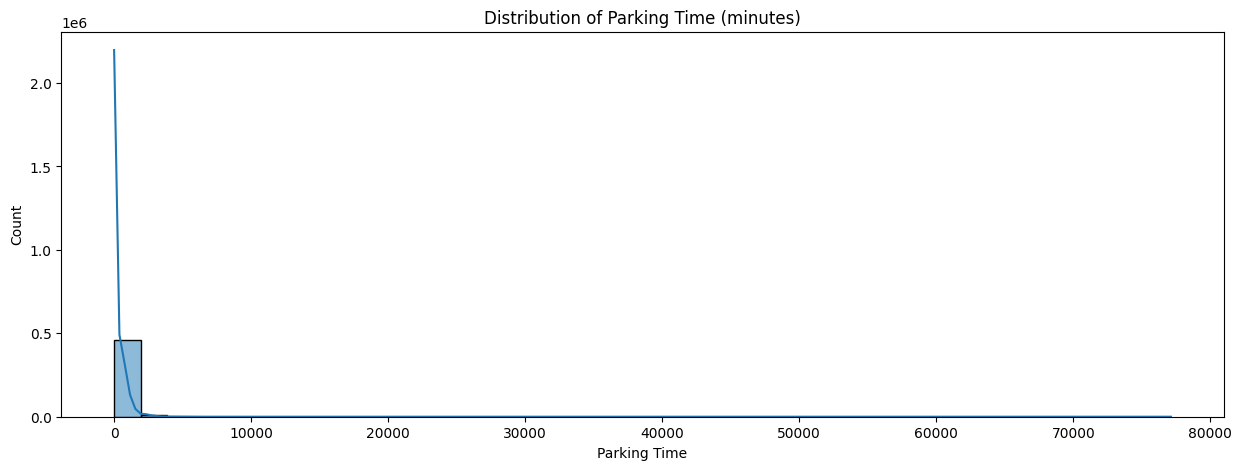

In [2]:
# Parking time distribution

plt.figure(figsize=(15,5))
sns.histplot(df["parking_time"], bins=40, kde=True)
plt.title("Distribution of Parking Time (minutes)")
plt.xlabel("Parking Time")
plt.ylabel("Count")
plt.show()

In [3]:
# Short parking times are much more frequent than long once.
# This phenomenon is aligned with the purpose of rental cars (vehicles are used repeatedly throughout the day and spend a short time parked between trips).

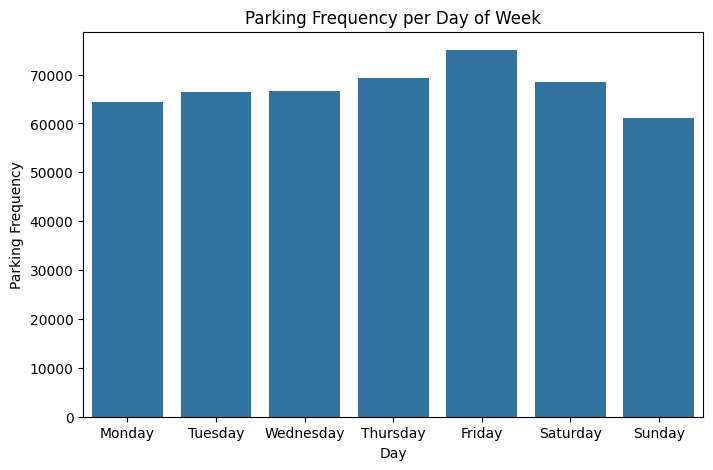

In [4]:
# Parking Frequency (sum) per Day of Week

plt.figure(figsize=(8,5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x="day_of_week_start", order=order)
plt.title("Parking Frequency per Day of Week")
plt.xlabel("Day")
plt.ylabel("Parking Frequency")
plt.show()

In [5]:
# Fridays are the most popular days (parking frequency = many uses through the day)

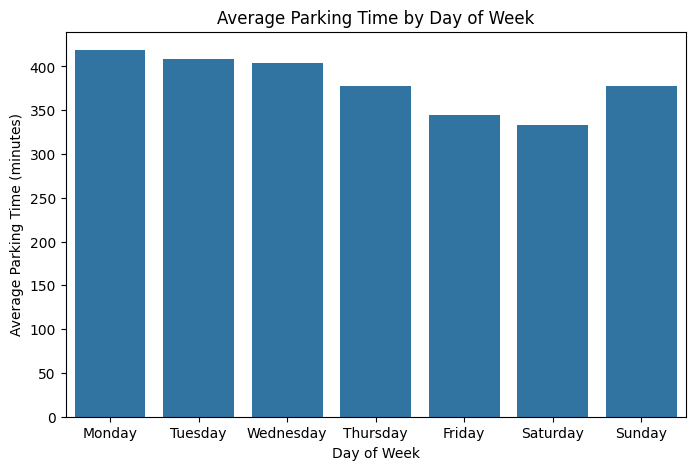

In [6]:
# Average Parking Time

plt.figure(figsize=(8,5))
sns.barplot(data=df, x='day_of_week_start',y='parking_time', order=order, errorbar=None)
plt.title('Average Parking Time by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Parking Time (minutes)')
plt.show()

In [7]:
# On average, saturday has the shortest parking times. 
# This could mean, that on Saturdays the cars are used longer. They are popular days based on parking frequency, but the parking times are low.

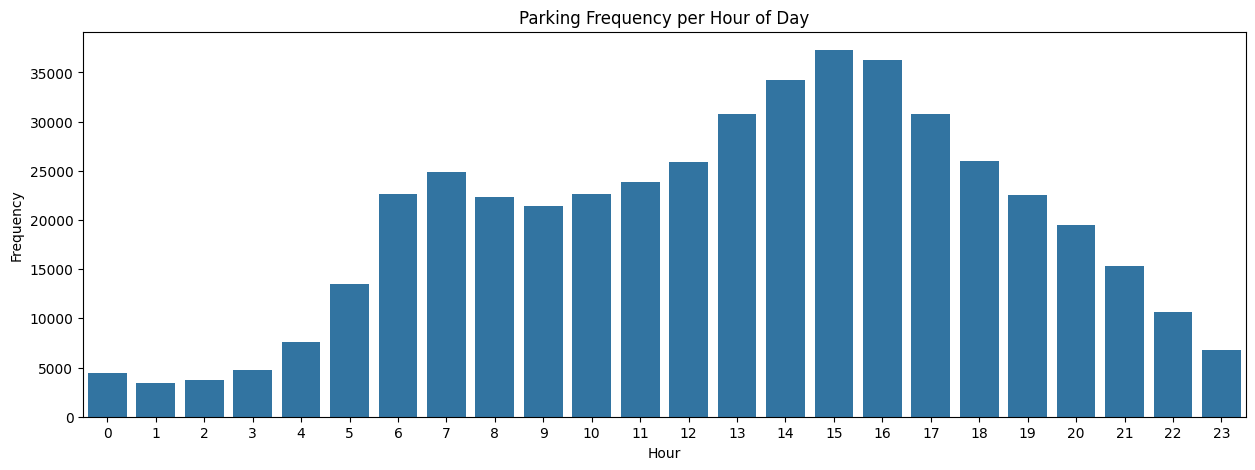

In [8]:
# Parking Frequency per Hour of Day

plt.figure(figsize=(15,5))
sns.countplot(data=df, x="hour_of_day_start")
plt.title("Parking Frequency per Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Around 3pm the parking frequency is at its highest. This means that the cars are often returned then (parking started at 3pm the most).

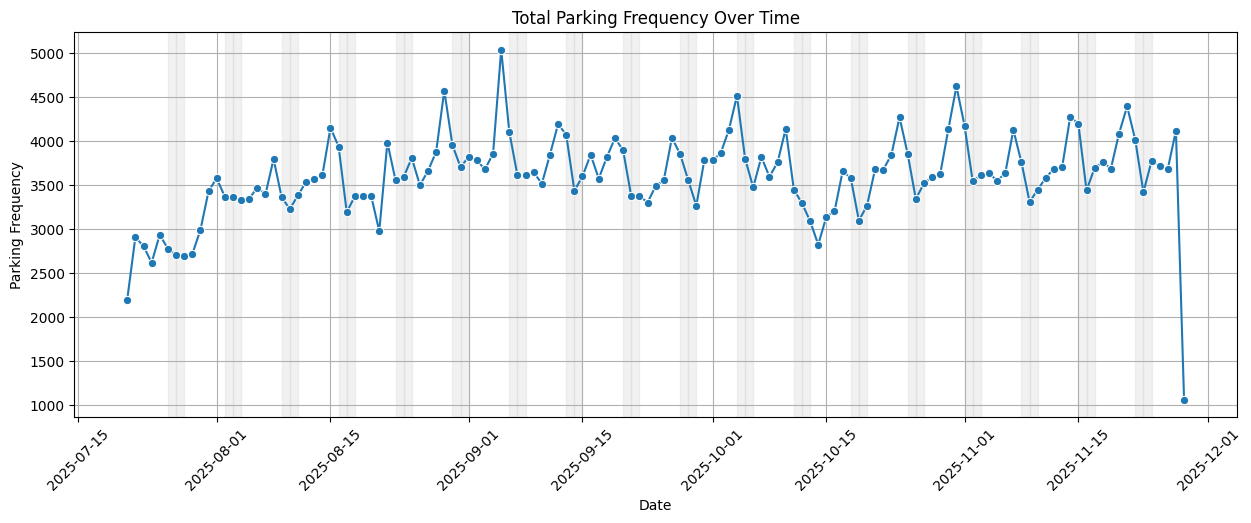

In [10]:
# Total Parking Frequency (weekends highlighted)

df['start_time'] = pd.to_datetime(df['start_time'])
df['parking_date'] = df['start_time'].dt.normalize()
parking_by_date = df.groupby('parking_date').size().reset_index(name='parking_count')

plt.figure(figsize=(15,5))
sns.lineplot(data=parking_by_date, x='parking_date', y='parking_count', marker='o')

for date in parking_by_date['parking_date']:
    if date.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        plt.axvspan(date, date + pd.Timedelta(days=1),
                    color='lightgray', alpha=0.3)

plt.title('Total Parking Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Parking Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [11]:
# If we observe the weekends (illustrated as grey bars on the visual), 
# we can see that right before the weekend, there is almost always a significant peak in parking frequency.

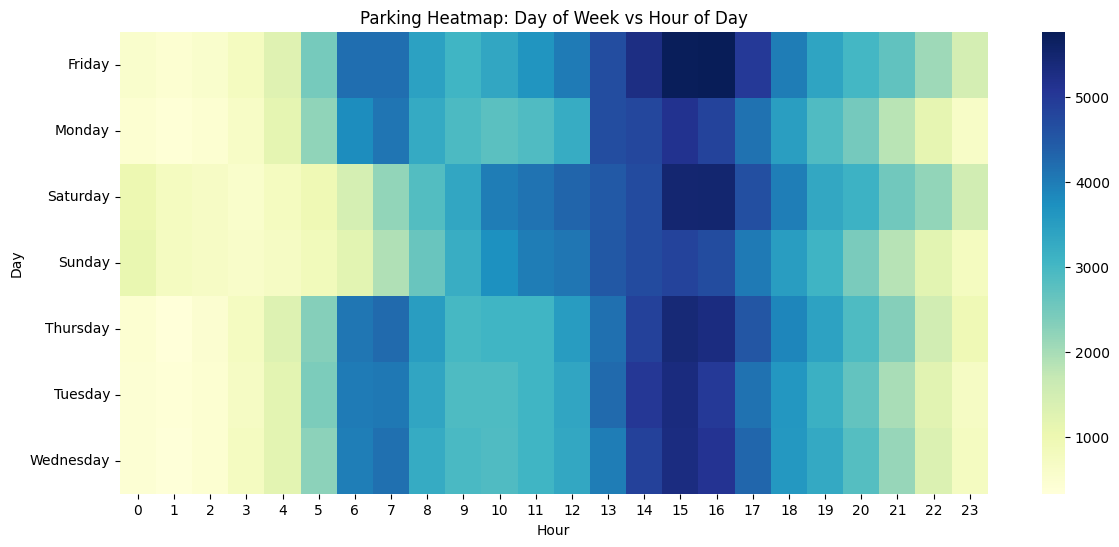

In [12]:
# Peak Hours and Days

pivot = df.pivot_table(index="day_of_week_start", columns="hour_of_day_start", values="licencePlate", aggfunc="count").fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Parking Heatmap: Day of Week vs Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Day")
plt.show()

In [13]:
# Above we can see that the most common parking times are aroung 6-7am and 1-5pm.
# The days with the highest parking frequencies are Friday, Saturday, and Thursday.

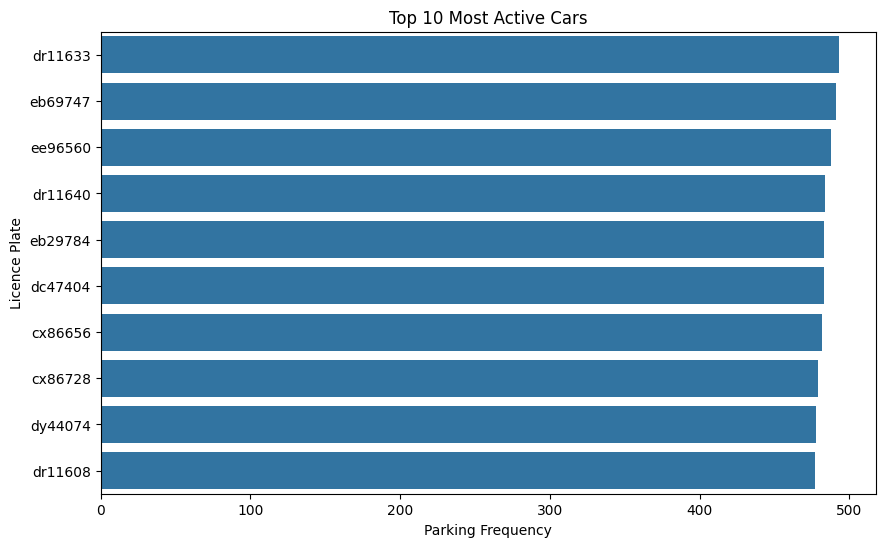

In [14]:
# Top 10 Most Active Cars

plt.figure(figsize=(10,6))
top_cars = df['licencePlate'].value_counts().head(10)
sns.barplot(x=top_cars.values, y=top_cars.index)
plt.title('Top 10 Most Active Cars')
plt.xlabel('Parking Frequency')
plt.ylabel('Licence Plate')
plt.show()

In [15]:
# The most active cars derived from the most parked cars.

In [ ]:
# 3D visual for Parking Frequency on each location

import pydeck as pdk

df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df = df.dropna(subset=['lon','lat'])

decimals = 4
agg3 = df.copy()
agg3['lon_round'] = agg3['lon'].round(decimals)
agg3['lat_round'] = agg3['lat'].round(decimals)
agg3 = agg3.groupby(['lon_round', 'lat_round']).size().reset_index(name='count')
agg3.rename(columns={'lon_round': 'lon', 'lat_round': 'lat'}, inplace=True)

center_lat = agg3['lat'].mean() if not agg3['lat'].isna().all() else df['lat'].mean()
center_lon = agg3['lon'].mean() if not agg3['lon'].isna().all() else df['lon'].mean()

initial_view = pdk.ViewState(latitude=center_lat, longitude=center_lon, zoom=10, pitch=80, bearing=-80)

def color_scale(count):
    if count > 100:
        return [2, 240, 70]
    elif count > 50:
        return [29, 180, 245]
    elif count > 20:
        return [29, 180, 245]
    else:
        return [14, 2, 240]

agg3["color"] = agg3["count"].apply(color_scale)

column_layer = pdk.Layer(
    "ColumnLayer",
    data=agg3,
    get_position=["lon", "lat"],
    get_elevation="count",
    elevation_scale=5,
    radius=30,
    get_fill_color="color",
    pickable=True,
)

r = pdk.Deck(layers=[column_layer], initial_view_state=initial_view, tooltip={"text": "Count: {count}"})
r

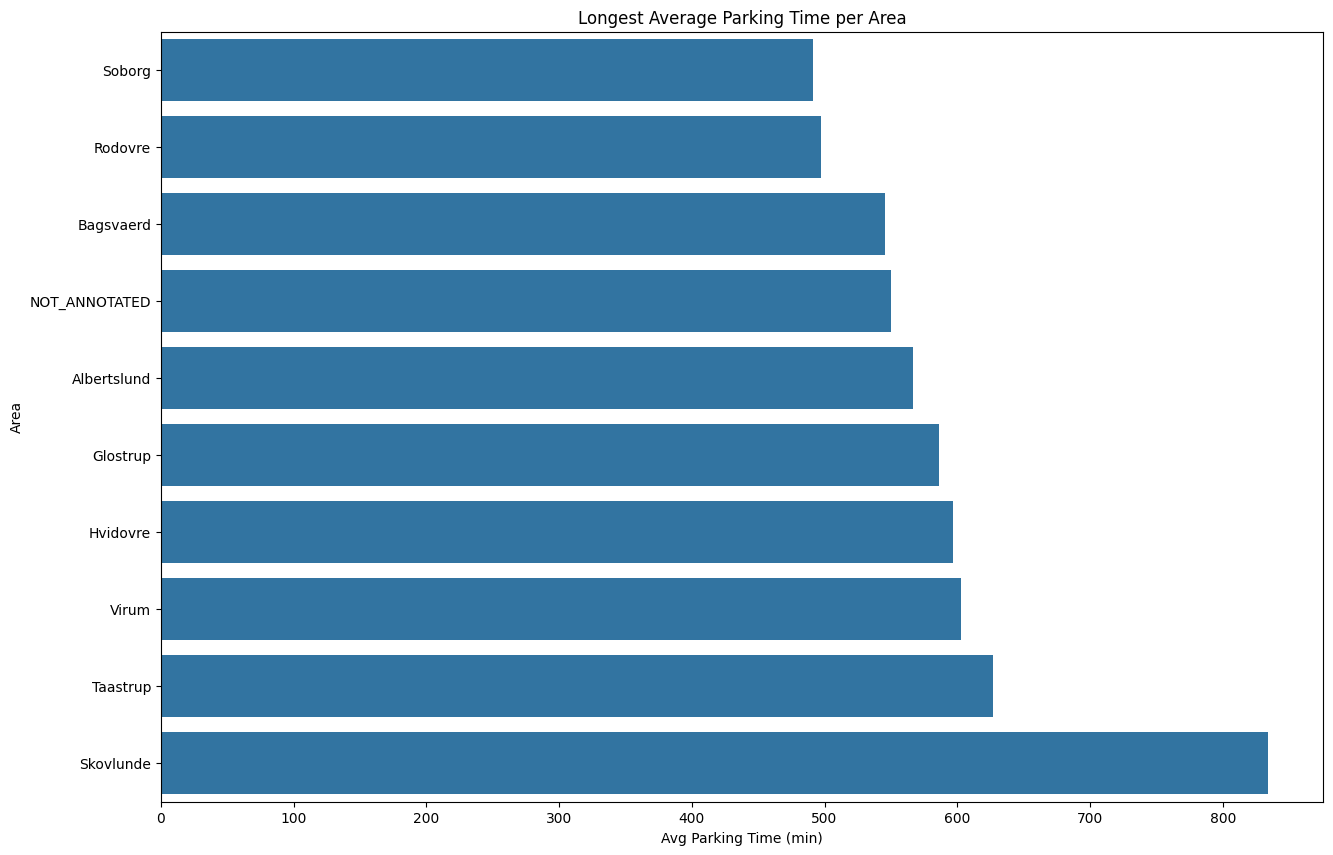

In [16]:
# Longest Average Parking Time per area

area_times = df.groupby("area_name")["parking_time"].mean().sort_values().tail(10)
plt.figure(figsize=(15,10))
sns.barplot(x=area_times.values, y=area_times.index)
plt.title("Longest Average Parking Time per Area")
plt.xlabel("Avg Parking Time (min)")
plt.ylabel("Area")
plt.show()

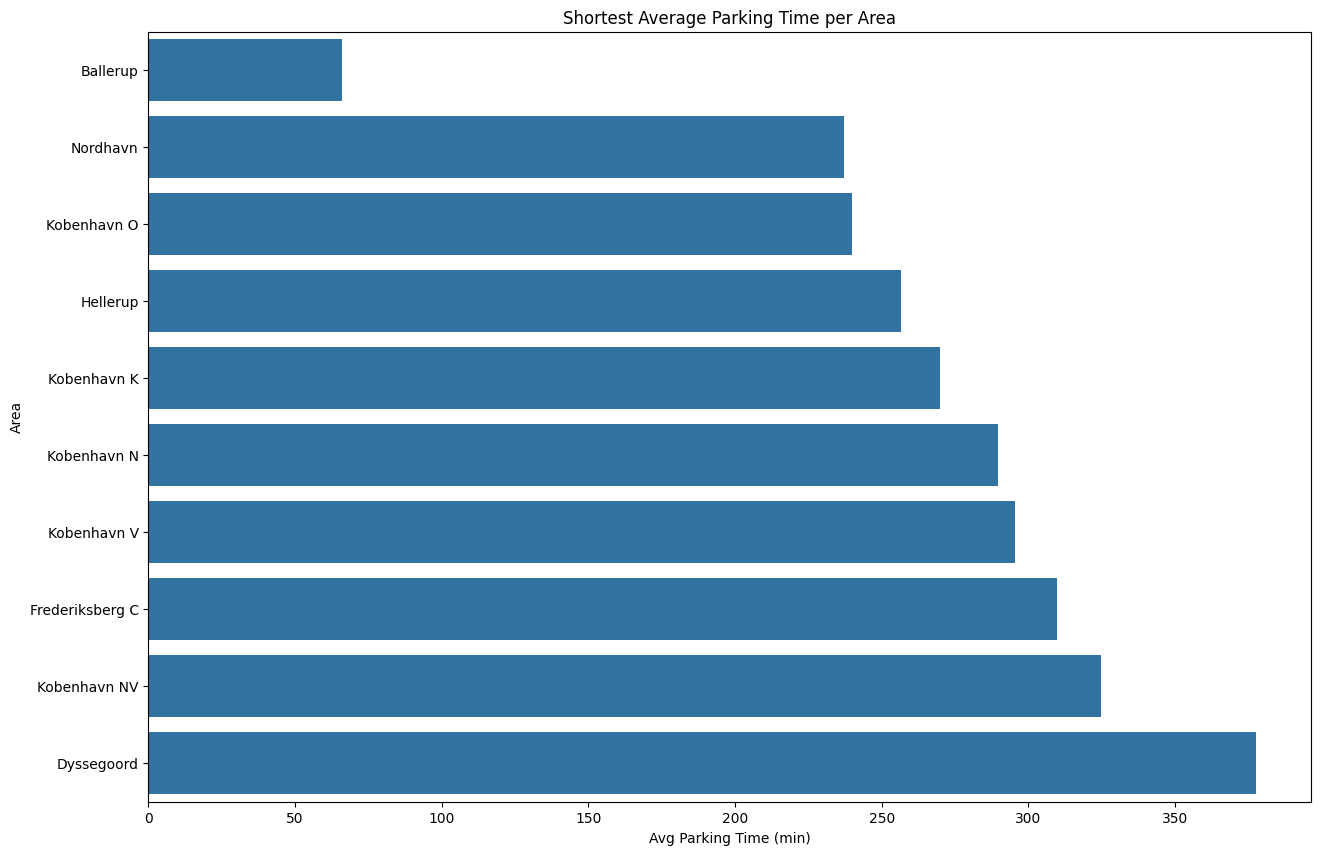

In [17]:
# Shortest Average Parking Time per area

area_times = df.groupby("area_name")["parking_time"].mean().sort_values().head(10)
plt.figure(figsize=(15,10))
sns.barplot(x=area_times.values, y=area_times.index)
plt.title("Shortest Average Parking Time per Area")
plt.xlabel("Avg Parking Time (min)")
plt.ylabel("Area")
plt.show()

In [18]:
# We can see that Skovlunde has clearly the longest parking times on average --> less traffic in that area.
# On the other hand, Ballerup has clearly the shortes parking times on average. (Only about an hour until the cars are used again)

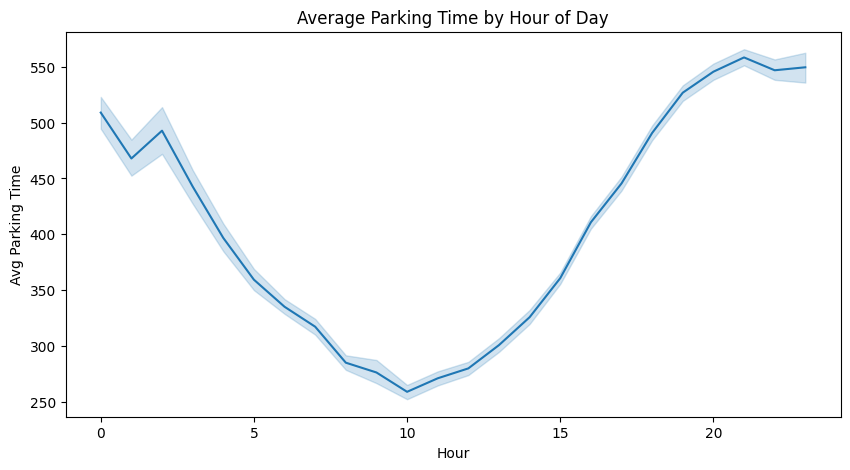

In [19]:
# Average Parking Time per hour of day

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x="hour_of_day_start", y="parking_time", estimator="mean")
plt.title("Average Parking Time by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg Parking Time")
plt.show()

In [20]:
# As can be expected, the parking times are significantly longer during nighttime.
# The shortest parking times occur around 10am.

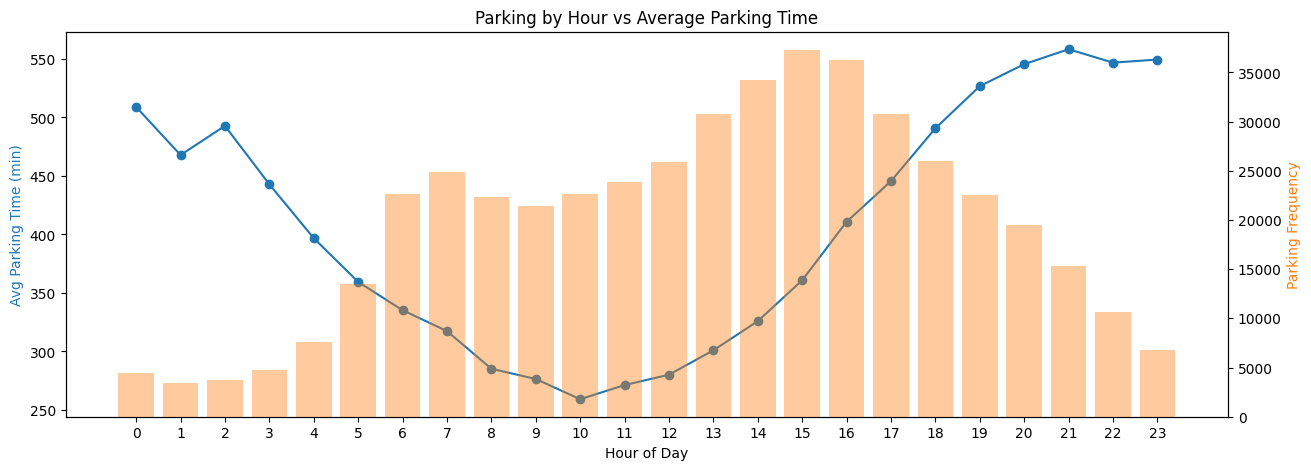

In [21]:
# Parking by Hour (frequency) versus Average Parking Time

avg_by_hour = df.groupby('hour_of_day_start')['parking_time'].mean()
count_by_hour = df['hour_of_day_start'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Parking Time (min)', color='tab:blue')
ax1.plot(avg_by_hour.index, avg_by_hour.values, color='tab:blue', marker='o', label='Avg Parking Time')

ax2 = ax1.twinx()
ax2.set_ylabel('Parking Frequency', color='tab:orange')
ax2.bar(count_by_hour.index, count_by_hour.values, color='tab:orange', alpha=0.4, label='Parking Frequency')

plt.title('Parking by Hour vs Average Parking Time')
plt.xticks(range(0, 24))
plt.show()

In [22]:
# The above visual illustrates how the parking frequency is low during nighttime, and consequently the cars stay parked longer on average.
# The most frequent use occurs around 3pm, when the parking time is about 350 minutes on average (5,8h).